  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], G Loss: 1.1442, D Loss: 7.7446


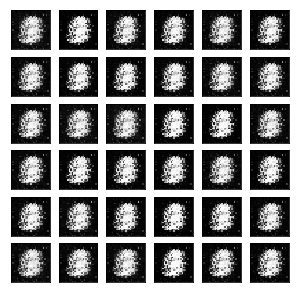

  4%|▍         | 1/25 [00:25<10:17, 25.72s/it]

Epoch[2/25], G Loss: 0.8359, D Loss: 7.8403


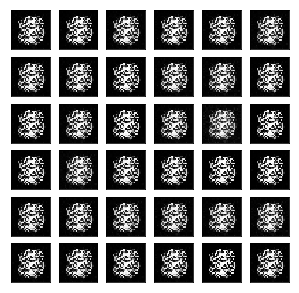

  8%|▊         | 2/25 [00:50<09:39, 25.19s/it]

Epoch[3/25], G Loss: 0.6852, D Loss: 7.5307


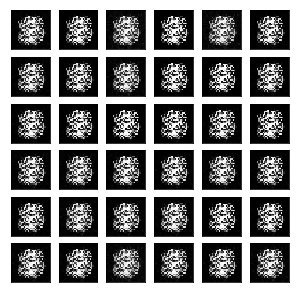

 12%|█▏        | 3/25 [01:15<09:13, 25.15s/it]

Epoch[4/25], G Loss: 0.7157, D Loss: 8.5767


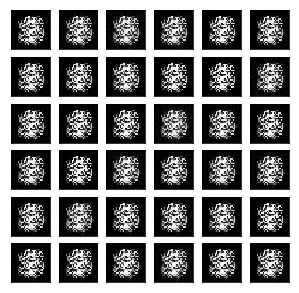

 16%|█▌        | 4/25 [01:40<08:47, 25.14s/it]

Epoch[5/25], G Loss: 0.7500, D Loss: 8.8671


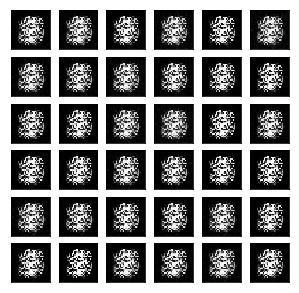

 20%|██        | 5/25 [02:04<08:17, 24.87s/it]

Epoch[6/25], G Loss: 0.7578, D Loss: 8.9712


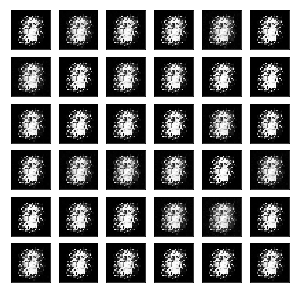

 24%|██▍       | 6/25 [02:28<07:50, 24.79s/it]

Epoch[7/25], G Loss: 0.7462, D Loss: 8.9696


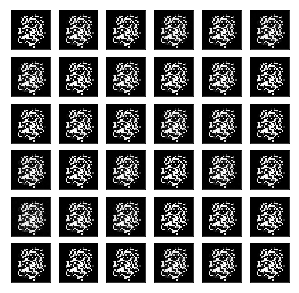

 28%|██▊       | 7/25 [02:53<07:25, 24.75s/it]

Epoch[8/25], G Loss: 0.8374, D Loss: 8.8280


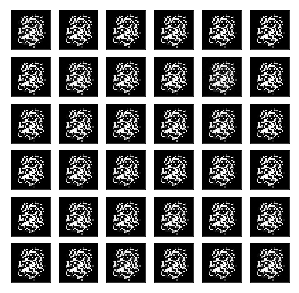

 32%|███▏      | 8/25 [03:20<07:05, 25.00s/it]

Epoch[9/25], G Loss: 0.8630, D Loss: 8.7680


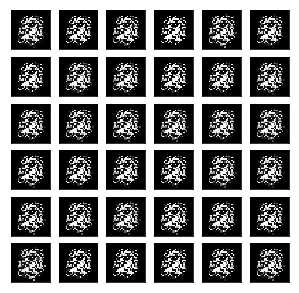

 36%|███▌      | 9/25 [03:47<06:44, 25.29s/it]

Epoch[10/25], G Loss: 0.8808, D Loss: 8.7086


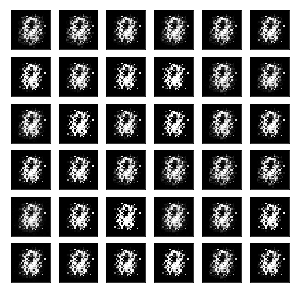

 40%|████      | 10/25 [04:20<06:30, 26.00s/it]

Epoch[11/25], G Loss: 0.7828, D Loss: 8.5472


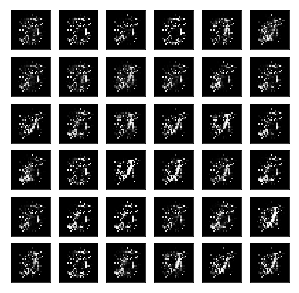

 44%|████▍     | 11/25 [04:44<06:02, 25.88s/it]

Epoch[12/25], G Loss: 0.6774, D Loss: 7.9821


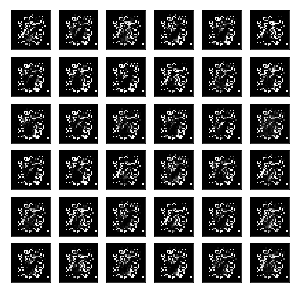

 48%|████▊     | 12/25 [05:09<05:35, 25.81s/it]

Epoch[13/25], G Loss: 1.2993, D Loss: 8.0355


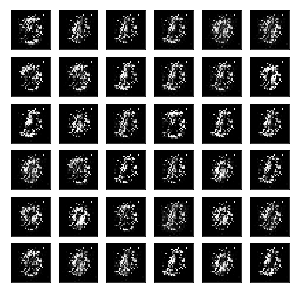

 52%|█████▏    | 13/25 [05:34<05:08, 25.73s/it]

Epoch[14/25], G Loss: 0.7671, D Loss: 8.3850


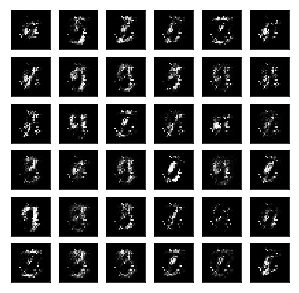

 56%|█████▌    | 14/25 [05:59<04:42, 25.68s/it]

Epoch[15/25], G Loss: 0.8160, D Loss: 8.1239


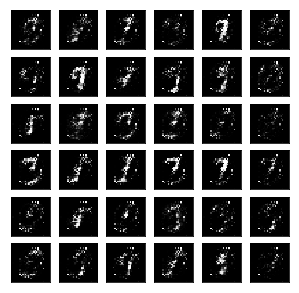

 60%|██████    | 15/25 [06:17<04:11, 25.20s/it]

Epoch[16/25], G Loss: 0.7402, D Loss: 7.8540


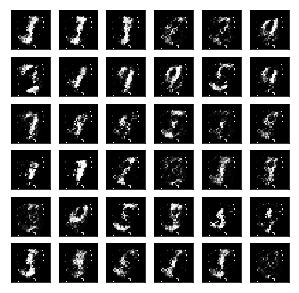

 64%|██████▍   | 16/25 [06:36<03:42, 24.76s/it]

Epoch[17/25], G Loss: 1.0690, D Loss: 4.2525


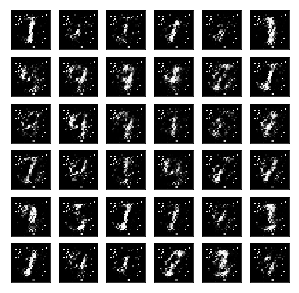

 68%|██████▊   | 17/25 [07:00<03:17, 24.74s/it]

Epoch[18/25], G Loss: 1.8928, D Loss: 1.7571


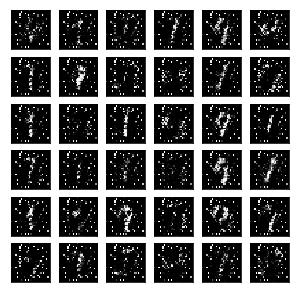

 72%|███████▏  | 18/25 [07:20<02:51, 24.48s/it]

Epoch[19/25], G Loss: 2.6882, D Loss: 1.4451


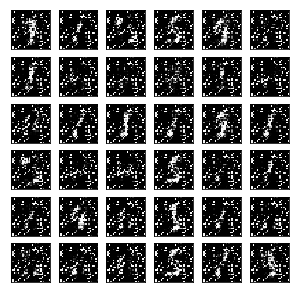

 76%|███████▌  | 19/25 [07:36<02:24, 24.04s/it]

Epoch[20/25], G Loss: 3.3539, D Loss: 0.9544


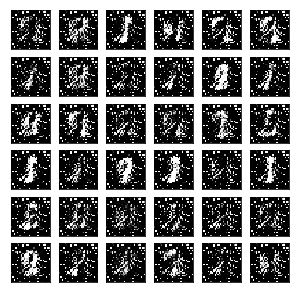

 80%|████████  | 20/25 [07:51<01:57, 23.59s/it]

Epoch[21/25], G Loss: 3.4602, D Loss: 0.8429


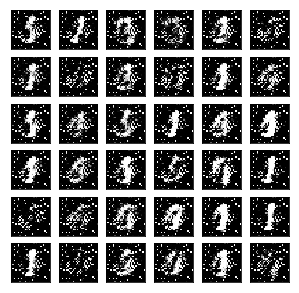

 84%|████████▍ | 21/25 [08:10<01:33, 23.35s/it]

Epoch[22/25], G Loss: 3.3196, D Loss: 0.6803


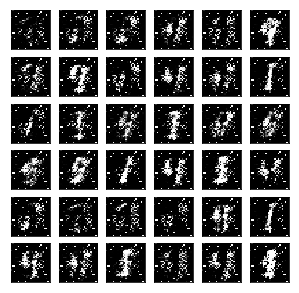

 88%|████████▊ | 22/25 [08:33<01:10, 23.35s/it]

Epoch[23/25], G Loss: 2.9322, D Loss: 0.5566


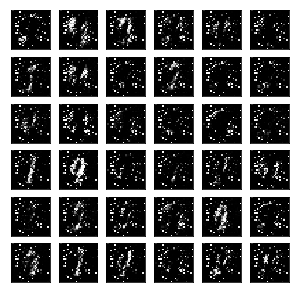

 92%|█████████▏| 23/25 [08:55<00:46, 23.27s/it]

Epoch[24/25], G Loss: 2.7278, D Loss: 0.5221


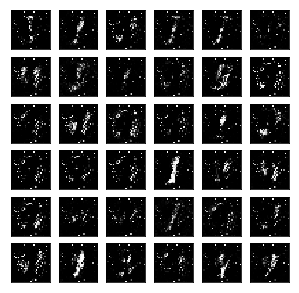

 96%|█████████▌| 24/25 [09:14<00:23, 23.09s/it]

Epoch[25/25], G Loss: 1.8347, D Loss: 0.8153


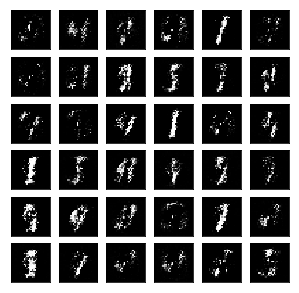

100%|██████████| 25/25 [09:37<00:00, 23.11s/it]


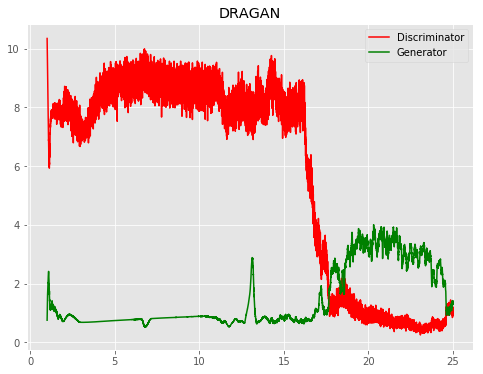

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.dra_gan import *
    
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = DRAGAN(image_size=784,
               hidden_dim=400,
               z_dim=20)

# Init trainer
trainer = DRAGANTrainer(model=model,
                        train_iter=train_iter,
                        val_iter=val_iter,
                        test_iter=test_iter,
                        viz=True)

# Train
trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)

# Show loss
trainer.viz_loss()